### *Imports necesarios para el proyecto*

In [ ]:
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import DenseNet121
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from datetime import timedelta
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### *Función para la creación del modelo*

In [ ]:
def create_densenet_model(input_size=200, num_classes=10):
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(input_size, input_size, 3),
        pooling=None)

    model = models.Sequential([
        base_model,

        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),

        layers.Dense(512,
                     kernel_regularizer=regularizers.L1L2(l1=0.0009, l2=0.005),
                     kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),

        layers.Dense(256,
                     kernel_regularizer=regularizers.L1L2(l1=0.0009, l2=0.005),
                     kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')])

    return model

### *Implementación de la función de visualización del progreso del modelo* 

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3), layout='constrained')

  ax1.plot(history.history['loss'],  #Visualización del histórico de la funcion de perdida en el set de entrenamiento
           label='train_loss',
           color='r',
           linewidth=2)
  ax1.plot(history.history['val_loss'],  #Visualización del histórico de la funcion de perdida en el set de validación
           label='val_loss',
           color='k',
           linewidth=2)
  ax1.set_title('Evolución De La Funcion De Perdida')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()

  ax2.plot(history.history['accuracy'],  #Visualización de la evolución del accuracy del modelo en el set de entrenamiento
           label='train_accuracy',
           color='r',
           linewidth=2)
  ax2.plot(history.history['val_accuracy'],  #Visualización de la evolución del accuracy del modelo en el set de validación
           label='val_accuracy',
           color='k',
           linewidth=2)
  ax2.set_title('Evolución Del Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.suptitle(f'Comparación Entre El Acc y El Loss De Train y Val', fontsize=10)
  plt.show()

In [ ]:
train_dir = '/content/drive/MyDrive/M3_U1_02/train'
test_dir = '/content/drive/MyDrive/M3_U1_02/test'
val_dir = '/content/drive/MyDrive/M3_U1_02/val'

### *Importación de los datos*

In [ ]:
train_generator = ImageDataGenerator(rescale=1./255,  #Instanciación del objeto ImageDataGenerator para la augmentación y la normalización de imagenes 
                                   rotation_range=40,
                                   zoom_range=0.3,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   brightness_range=[0.7, 1.3],
                                   horizontal_flip=True,
                                   fill_mode='nearest')  

test_generator = ImageDataGenerator(rescale=1./255)

train = train_generator.flow_from_directory(train_dir,
                                            target_size=(200, 200),
                                            class_mode='categorical',
                                            batch_size=32,
                                            shuffle=True)

test = test_generator.flow_from_directory(test_dir,
                                          target_size=(200, 200),
                                          class_mode='categorical',
                                          batch_size=32,
                                          shuffle=False)

val = test_generator.flow_from_directory(val_dir,
                                         target_size=(200, 200),
                                         class_mode='categorical',
                                         batch_size=32,
                                         shuffle=False)

Found 9020 images belonging to 10 classes.
Found 990 images belonging to 10 classes.
Found 990 images belonging to 10 classes.


### *Instanciación del modelo*

In [ ]:
model = create_densenet_model()

base_model = model.layers[0]

base_model.trainable = False

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 6, 6, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,703,370 (29.39 MB)

 Trainable params: 662,282 (2.53 MB)

 Non-trainable params: 7,041,088 (26.86 MB)

### *Cálculo de los pesos de las clases de la variable objetivo*

In [ ]:
class_distribution = Counter(train.classes)

total_samples = sum(class_distribution.values())
class_weights = {class_id: total_samples / count for class_id, count in class_distribution.items()}

mean_weight = np.mean(list(class_weights.values()))
class_weights = {k: v / mean_weight for k, v in class_weights.items()}

### *Callbacks para la monitorización del progreso del modelo*

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss',
                                     patience=5,
                                     restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.85,
                                        patience=5)

checkpoint_cb = callbacks.ModelCheckpoint('best_model.keras',
                                          save_best_only=True,
                                          monitor='val_loss',
                                          mode='min',
                                          verbose=1)

In [ ]:
initial_lr = 3e-4

epochs = 5

full_layers = len(DenseNet121(weights=None).layers)

trainable_schedule = [0, full_layers//4, full_layers//2, full_layers]

optimizers_schedule = [optimizers.AdamW(learning_rate=initial_lr),
                       optimizers.AdamW(learning_rate=initial_lr/10),
                       optimizers.SGD(learning_rate=initial_lr/10, momentum=0.9),
                       optimizers.SGD(learning_rate=initial_lr/100, momentum=0.9)]

### *Bucle para la visualización de la función de perdida y el accuracy en cada fase del entrenamiento del modelo*


Fase 1: 0 Capas Descongeladas
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.6376 - loss: 26.0703
Epoch 1: val_loss improved from inf to 12.63603, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 386s 820ms/step - accuracy: 0.6380 - loss: 26.0515 - val_accuracy: 0.8152 - val_loss: 12.6360 - learning_rate: 3.0000e-04
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8625 - loss: 10.4538
Epoch 2: val_loss improved from 12.63603 to 5.86515, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 115s 407ms/step - accuracy: 0.8625 - loss: 10.4477 - val_accuracy: 0.8596 - val_loss: 5.8651 - learning_rate: 3.0000e-04
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8775 - loss: 4.9551
Epoch 3: val_loss improved from 5.86515 to 3.13122, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 114s 404ms/step - accuracy: 0.8775 - loss: 4.9526 - val_accuracy: 0.8727 - val_loss: 3.1312 - learning_rate: 3.0000e-04
Epo

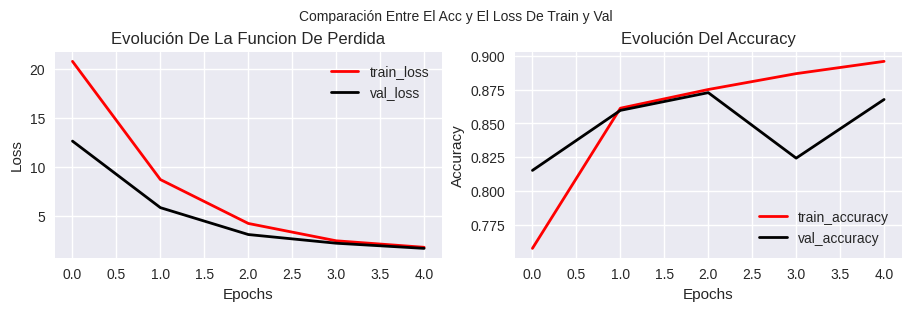


Fase 2: 107 Capas Descongeladas
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9316 - loss: 1.4751
Epoch 1: val_loss improved from 1.72361 to 1.19172, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 368s 769ms/step - accuracy: 0.9317 - loss: 1.4748 - val_accuracy: 0.9475 - val_loss: 1.1917 - learning_rate: 3.0000e-05
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9578 - loss: 1.1787
Epoch 2: val_loss improved from 1.19172 to 1.07553, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 117s 414ms/step - accuracy: 0.9578 - loss: 1.1786 - val_accuracy: 0.9515 - val_loss: 1.0755 - learning_rate: 3.0000e-05
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9639 - loss: 1.0648
Epoch 3: val_loss improved from 1.07553 to 1.00615, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 116s 410ms/step - accuracy: 0.9639 - loss: 1.0647 - val_accuracy: 0.9596 - val_loss: 1.0061 - learning_rate: 3.0000e-05
Epoc

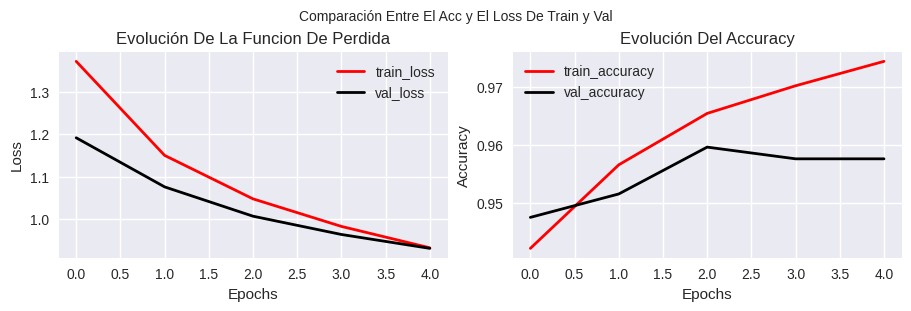


Fase 3: 214 Capas Descongeladas
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.9763 - loss: 0.9086
Epoch 1: val_loss improved from 0.93003 to 0.89780, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 308s 712ms/step - accuracy: 0.9763 - loss: 0.9085 - val_accuracy: 0.9606 - val_loss: 0.8978 - learning_rate: 3.0000e-05
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9766 - loss: 0.8858
Epoch 2: val_loss improved from 0.89780 to 0.88039, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 115s 408ms/step - accuracy: 0.9766 - loss: 0.8858 - val_accuracy: 0.9616 - val_loss: 0.8804 - learning_rate: 3.0000e-05
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9776 - loss: 0.8669
Epoch 3: val_loss improved from 0.88039 to 0.86984, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 114s 405ms/step - accuracy: 0.9776 - loss: 0.8669 - val_accuracy: 0.9626 - val_loss: 0.8698 - learning_rate: 3.0000e-05
Epoc

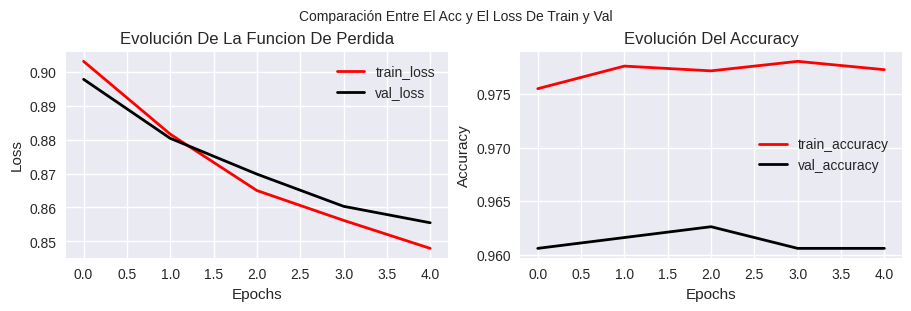


Fase 4: 429 Capas Descongeladas
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.9795 - loss: 0.8395
Epoch 1: val_loss improved from 0.85548 to 0.85359, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 292s 681ms/step - accuracy: 0.9795 - loss: 0.8395 - val_accuracy: 0.9606 - val_loss: 0.8536 - learning_rate: 3.0000e-06
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9802 - loss: 0.8375
Epoch 2: val_loss improved from 0.85359 to 0.85236, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 112s 395ms/step - accuracy: 0.9802 - loss: 0.8375 - val_accuracy: 0.9606 - val_loss: 0.8524 - learning_rate: 3.0000e-06
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9806 - loss: 0.8359
Epoch 3: val_loss improved from 0.85236 to 0.85155, saving model to best_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 111s 391ms/step - accuracy: 0.9806 - loss: 0.8359 - val_accuracy: 0.9616 - val_loss: 0.8516 - learning_rate: 3.0000e-06
Epoc

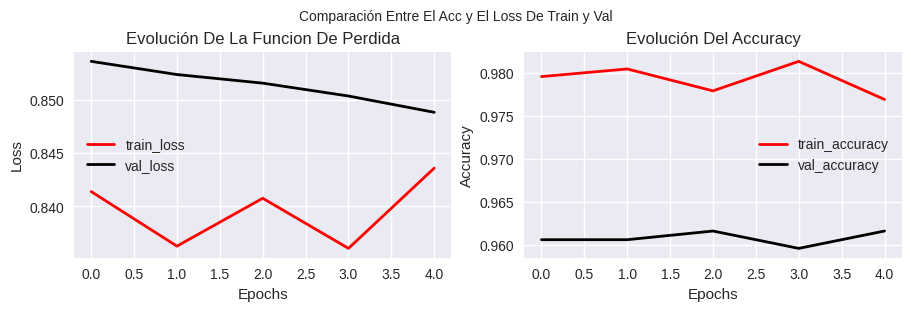

In [ ]:
complete_history = {'history_loss': [], 'history_acc': []}

for phase, (trainable, opt) in enumerate(zip(trainable_schedule, optimizers_schedule)):

    print(f'\nFase {phase+1}: {trainable} Capas Descongeladas')

    for layer in base_model.layers[-trainable:]:
        layer.trainable = True

    opt = optimizers_schedule[phase]
    model.compile(optimizer=opt, 
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
                  metrics=['accuracy'])

    history = model.fit(train,
                        epochs=epochs,
                        validation_data=val,
                        callbacks=[early_stop, reduce_lr, checkpoint_cb],
                        class_weight=class_weights,
                        verbose=1)
    complete_history['history_loss'].extend(history.history['val_loss'])
    complete_history['history_acc'].extend(history.history['val_accuracy'])

    plot_history(history)

### *Visualización del progreso del modelo durante todo el entrenamiento*

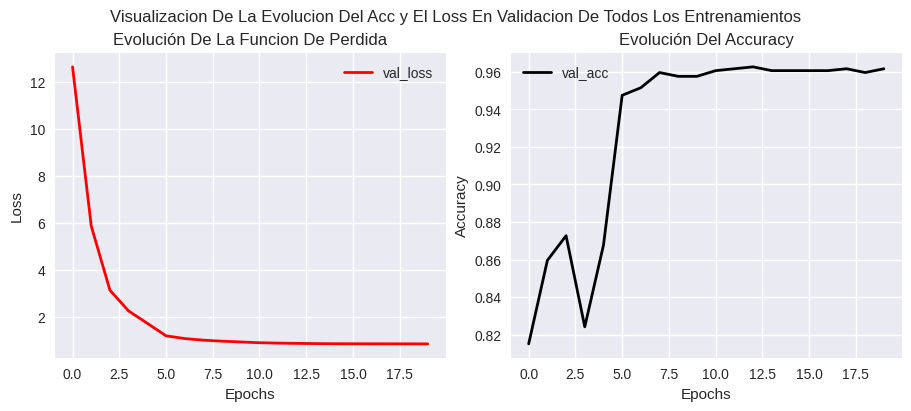

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), layout='constrained')

ax1.plot(complete_history['history_loss'],
         label='val_loss',
         color='r',
         linewidth=2)
ax1.set_title('Evolución De La Funcion De Perdida')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(complete_history['history_acc'],
         label='val_acc',
         color='k',
         linewidth=2)
ax2.set_title('Evolución Del Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.suptitle('Visualizacion De La Evolucion Del Acc y El Loss En Validacion De Todos Los Entrenamientos')
plt.show()

In [ ]:
model.load_weights('best_model.keras')
val_loss, val_acc = model.evaluate(test)
print(f'\nModelo Final:\nAccuracy: {val_acc:.4f}\nLoss: {val_loss:.4f}')

31/31 ━━━━━━━━━━━━━━━━━━━━ 565s 19s/step - accuracy: 0.9741 - loss: 0.8321

Modelo Final:
Accuracy: 0.9687
Loss: 0.8471


### *Predicción del modelo*

In [ ]:
y_pred = np.argmax(model.predict(test), axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 445ms/step


### *Matriz de confusión para el analisis de las predicciones*

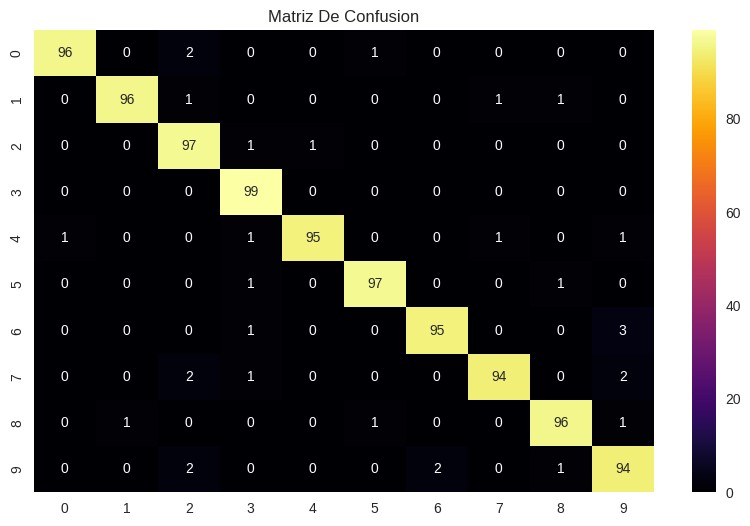

In [ ]:
cf = confusion_matrix(test.classes, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cf,
            annot=True,
            cmap='inferno',
            fmt='d')
plt.title('Matriz De Confusion')
plt.show()

### *Reporte de clasificación para el analisis del modelo*

In [ ]:
cr = classification_report(test.classes, y_pred)

print(cr)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        99
           1       0.99      0.97      0.98        99
           2       0.93      0.98      0.96        99
           3       0.95      1.00      0.98        99
           4       0.99      0.96      0.97        99
           5       0.98      0.98      0.98        99
           6       0.98      0.96      0.97        99
           7       0.98      0.95      0.96        99
           8       0.97      0.97      0.97        99
           9       0.93      0.95      0.94        99

    accuracy                           0.97       990
   macro avg       0.97      0.97      0.97       990
weighted avg       0.97      0.97      0.97       990

